## Reliability of Datasets
3 Ways to calculate the reliability of datasetmeans:
- Using reliability of individual subjects (optimistic)
- Using half estimations of dataset mean (realistic)
- Using Variance decomposition $\frac{Var(W_u + W_d)}{Var(W_u + W_d + W_s + \epsilon)}$

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import Functional_Fusion.reliability as rel
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.evaluation as ev
import matplotlib.pyplot as plt
from tqdm import tqdm
import SUITPy as suit
import Functional_Fusion.atlas_map as at

In [2]:
def calc_group_reliability(R_list):
    N = len(R_list)
    mean_R = np.mean(R_list, axis=0)
    R = (N*mean_R) / ((N-1)*mean_R + 1)
    return R

In [18]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1]):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale)

In [3]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
train_ses = ["all", "ses-localizer_cond", "all", "all", "all", "all", "all"]
logalpha_list = [6, 6, 6, 2, 2, 8, 6]
cerebellum = "MNISymC3"

In [4]:
# Load the product matrix and metadata vectors 
data = np.load("/home/UWO/ashahb7/Github/bayes_temp/bestSTD_product_matrix.npz", allow_pickle=True)
# select subset of covariance matrix
indices = []
for ds, la in zip(dataset_list, logalpha_list):
    indices.append(np.where((data['dataset_vec'] == ds) & (data['logalpha_vec'] == la))[0])
indices = np.concatenate(indices)
covariance_mat = data['product_matrix'][np.ix_(indices, indices)]
dataset_vec = data['dataset_vec'][indices]
sub_vec = data['sub_vec'][indices]
part_vec = data['part_vec'][indices]

# Calculate the norm of each original vector to convert covariance matrix to correlation matrix
norm_vec = np.zeros(len(dataset_vec))
norm_vec = np.sqrt(np.diag(covariance_mat))# * (1876 * 5446))
cos_sim_mat = covariance_mat / np.outer(norm_vec, norm_vec)

In [5]:
reliability_df = pd.DataFrame(columns=["dataset", "subject", "R"])
for dataset in dataset_list:
    for subject in list(dict.fromkeys(sub_vec[dataset_vec == dataset])):
        mask = (dataset_vec == dataset) & (sub_vec == subject)
        ind = np.where(mask)[0]
        if len(ind) != 2:
            print(f"Warning: {dataset} {subject} has {len(ind)} parts")
        R = cos_sim_mat[ind[0], ind[1]]
        R_s = (2 * R) / (1 + R)
        reliability_df = pd.concat([reliability_df, pd.DataFrame([{"dataset": dataset, "subject": subject, "R": R_s}])], ignore_index=True)

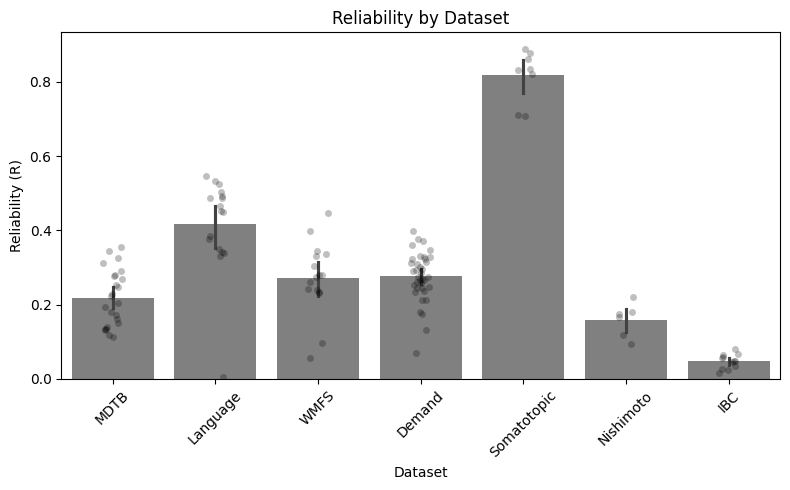

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(data=reliability_df, x="dataset", y="R", color="gray")
sns.stripplot(data=reliability_df, x="dataset", y="R", color="black", alpha=0.25, jitter=True)
plt.title("Reliability by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Reliability (R)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Calculate the dataset average model reliability

In [7]:
reliability_df["group_R"] = reliability_df["dataset"].map(
    {dataset: calc_group_reliability(reliability_df[reliability_df["dataset"] == dataset]["R"].values) for dataset in dataset_list}
)   

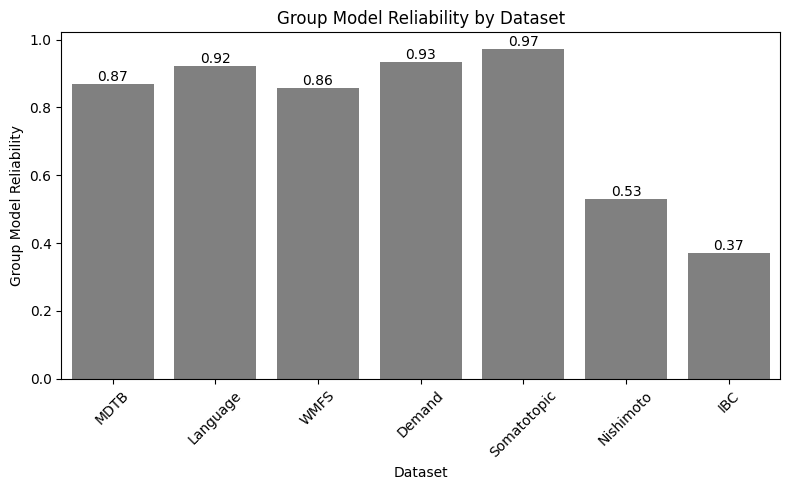

In [8]:
plt.figure(figsize=(8, 5))
sns.barplot(data=reliability_df.drop_duplicates(subset=["dataset"]).reset_index(), x="dataset", y="group_R", color="gray")

# Add annotations on top of each bar
for index, row in reliability_df.drop_duplicates(subset=["dataset"]).reset_index().iterrows():
    plt.annotate(f"{row['group_R']:.2f}", (index, row["group_R"]), ha="center", va="bottom")

plt.title("Group Model Reliability by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Group Model Reliability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Estimate the reliability based on variance decomposition

In [9]:
# Do variance decomposition
full_var_decom_df = rel.decompose_variance_scaled_from_SS(covariance_mat, dataset_vec, sub_vec, part_vec)

Bad pairs (cross-dataset): 8.74%
Bad pairs (cross-subject): 1.49%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%


In [10]:
# First level, across parts of same subject
decom_reliability_df = pd.DataFrame(columns=["dataset", "subject", "R"])
for _, row in full_var_decom_df.iterrows():
    R = (row["v_u"] + row["v_d"] + row["v_s"]) / (row["v_u"] + row["v_d"] + row["v_s"] + row["v_m"])
    decom_reliability_df = pd.concat(
        [decom_reliability_df, pd.DataFrame([{"dataset": row["train_dataset"], "subject": row["subj_id"], "R": R}])],
        ignore_index=True
    )

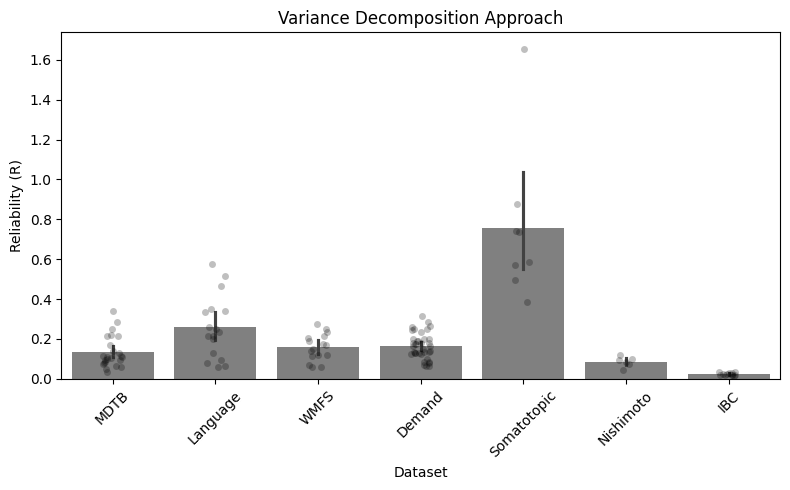

In [11]:
plt.figure(figsize=(8, 5))
sns.barplot(data=decom_reliability_df, x="dataset", y="R", color="gray")
sns.stripplot(data=decom_reliability_df, x="dataset", y="R", color="black", alpha=0.25, jitter=True)
plt.title("Variance Decomposition Approach")
plt.xlabel("Dataset")
plt.ylabel("Reliability (R)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
decom_reliability_df["group_R"] = (full_var_decom_df["v_u"] + full_var_decom_df["v_d"]) / (
    full_var_decom_df["v_u"] + full_var_decom_df["v_d"] + full_var_decom_df["v_s"] + full_var_decom_df["v_m"] / 2)

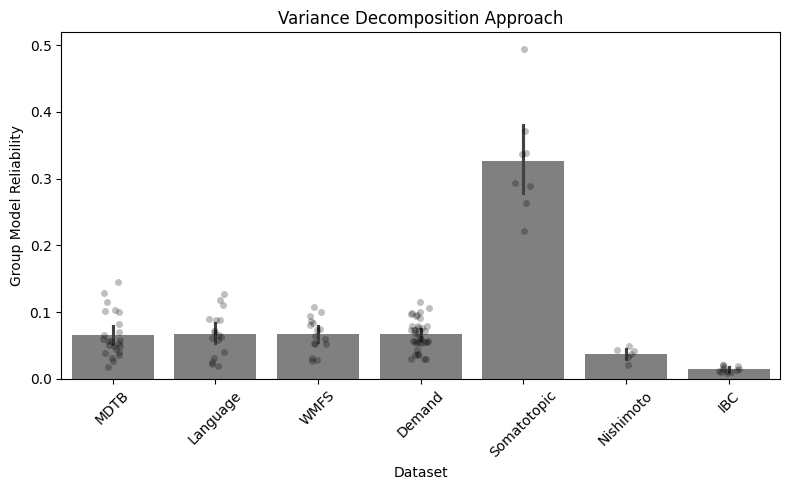

In [13]:
plt.figure(figsize=(8, 5))
sns.barplot(data=decom_reliability_df, x="dataset", y="group_R", color="gray")
sns.stripplot(data=decom_reliability_df, x="dataset", y="group_R", color="black", alpha=0.25, jitter=True)

plt.title("Variance Decomposition Approach")
plt.xlabel("Dataset")
plt.ylabel("Group Model Reliability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Do half1 - half2

In [20]:
half_reliability_df = pd.DataFrame(columns=["dataset", "group_R"])

method = 'L2reghalf'
R_map_list = []

for dataset_name, tses, la in tqdm(zip(dataset_list, train_ses, logalpha_list), total=len(dataset_list), desc="Processing datasets"):
    m_count = 0
    dirname = f"{dataset_name}_{tses}_Icosahedron1002_{method}"
    mname = f"{dataset_name}_{tses}_Icosahedron1002_{method}_A{la}"

    config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses='all', model='ind', cerebellum='MNISymC3', add_rest=True)
    dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
    config["subj_list"] = dataset.get_participants().participant_id

    fm, _ = rm.get_fitted_models([dirname], [mname], config)
    fm = fm[0]

    for conn_model in fm:
        if m_count == 0:
            avg_coef_1 = conn_model.coef_1
            avg_coef_2 = conn_model.coef_2
        else:
            avg_coef_1 += conn_model.coef_1
            avg_coef_2 += conn_model.coef_2
        m_count += 1
    avg_coef_1 /= m_count
    avg_coef_2 /= m_count
    R, R_vox = ev.calculate_R(avg_coef_1.T, avg_coef_2.T)
    R_map_list.append(R_vox)
    half_reliability_df = pd.concat(
        [half_reliability_df, pd.DataFrame([{"dataset": dataset_name, "group_R": R}])],
        ignore_index=True
    )

Processing datasets: 100%|██████████| 7/7 [05:25<00:00, 46.44s/it]


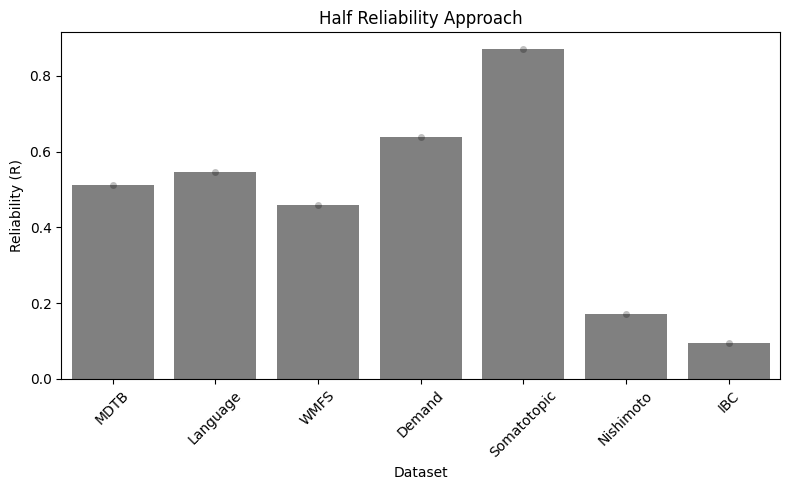

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(data=half_reliability_df, x="dataset", y="group_R", color="gray")
sns.stripplot(data=half_reliability_df, x="dataset", y="group_R", color="black", alpha=0.25, jitter=True)
plt.title("Half Reliability Approach")
plt.xlabel("Dataset")
plt.ylabel("Reliability (R)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

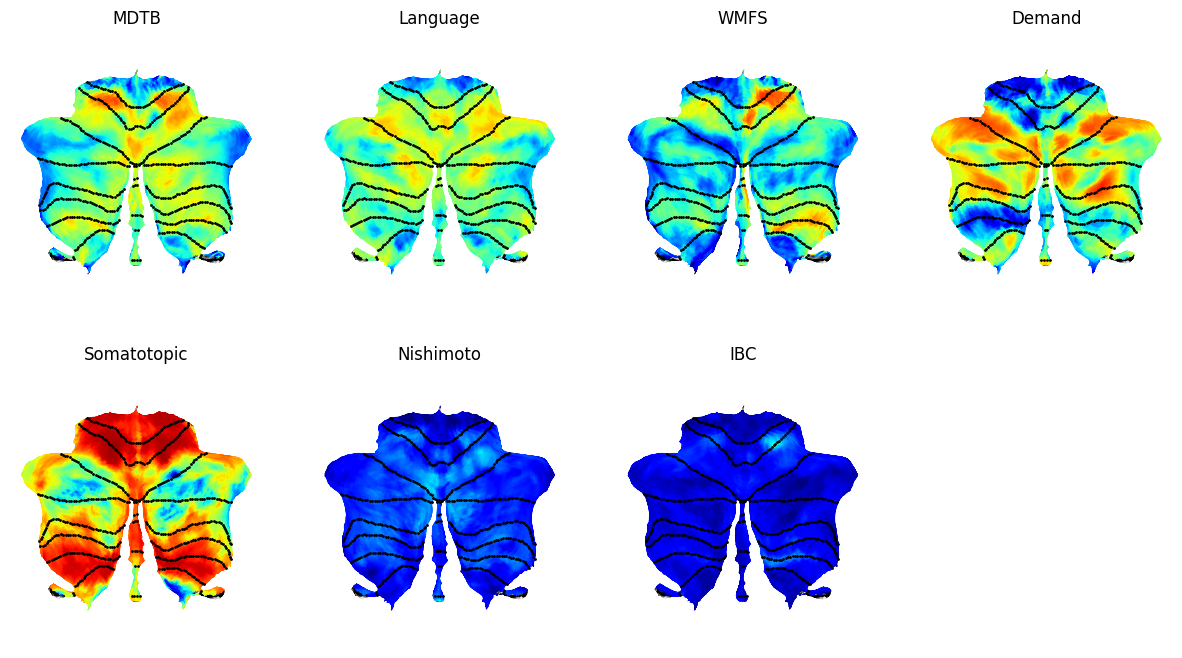

In [25]:
cereb_atlas,_ = at.get_atlas('MNISymC3')

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i, (R_map, dataset_name) in enumerate(zip(R_map_list, dataset_list)):
    plt.subplot(2, 4, i + 1)
    plot_cereb_data(R_map, cereb_atlas, cscale=[0, 1])
    plt.title(dataset_name)

# Remove the last unused subplot
fig.delaxes(axes[1, 3])

### Compare three approaches

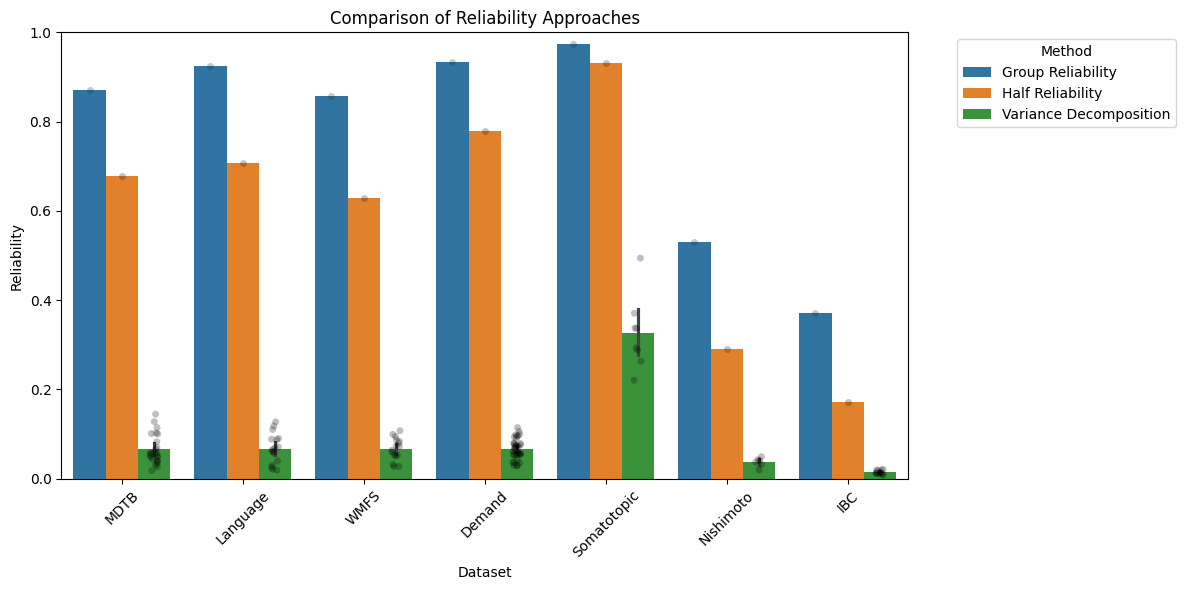

In [26]:
# Combine the three dataframes
half_reliability_df['Reliability'] = half_reliability_df['group_R'] * 2 / (1 + half_reliability_df['group_R'])
combined_df = pd.concat([
    reliability_df[["dataset", "group_R"]].drop_duplicates().rename(columns={"group_R": "Reliability"}).assign(Method="Group Reliability"),
    half_reliability_df[["dataset", "Reliability"]].assign(Method="Half Reliability"),
    decom_reliability_df[["dataset", "group_R"]].drop_duplicates().rename(columns={"group_R": "Reliability"}).assign(Method="Variance Decomposition"),
])

# Plot the combined dataframe
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x="dataset", y="Reliability", hue="Method")
sns.stripplot(data=combined_df, x="dataset", y="Reliability", hue="Method", dodge=True, alpha=0.25, jitter=True, palette="dark:black", legend=False)
plt.title("Comparison of Reliability Approaches")
plt.xlabel("Dataset")
plt.ylabel("Reliability")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()